In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#importing all required python libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
import os
from sklearn.metrics import mean_absolute_error
from sklearn import svm
from minepy import MINE#loading class to select features using MIC (Maximal Information Coefficient)
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, RepeatVector, Bidirectional, LSTM, GRU, AveragePooling2D
from keras.layers import Convolution2D
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
import pickle
import matplotlib.pyplot as plt #use to visualize dataset vallues
from keras.layers import *
from keras.models import *
from keras import backend as K
from sklearn.linear_model import LinearRegression

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [3]:
#defining self attention layer
class attention(Layer):
    def __init__(self, return_sequences=True, name=None, **kwargs):
        super(attention,self).__init__(name=name)
        self.return_sequences = return_sequences
        super(attention, self).__init__(**kwargs)

    def build(self, input_shape):

        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")

        super(attention,self).build(input_shape)

    def call(self, x):

        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

In [4]:
#class to normalize dataset values
scaler = MinMaxScaler(feature_range = (0, 1))
scaler1 = MinMaxScaler(feature_range = (0, 1))

In [5]:
#loading and displaying Aneshtesia clinical dataset
dataset = pd.read_csv("Dataset/household_power_consumption.csv", sep=";", nrows=10000)
#converting sub meter values as float data     
dataset['Sub_metering_1'] = dataset['Sub_metering_1'].astype(float)
dataset['Sub_metering_2'] = dataset['Sub_metering_2'].astype(float)
dataset['Sub_metering_3'] = dataset['Sub_metering_3'].astype(float)
dataset.fillna(0, inplace = True)
dataset

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
9995,23/12/2006,15:59:00,4.958,0.664,241.34,20.6,0.0,0.0,17.0
9996,23/12/2006,16:00:00,4.954,0.666,241.50,20.6,0.0,0.0,18.0
9997,23/12/2006,16:01:00,4.932,0.658,240.80,20.6,0.0,0.0,18.0
9998,23/12/2006,16:02:00,4.926,0.660,240.77,20.6,0.0,0.0,18.0


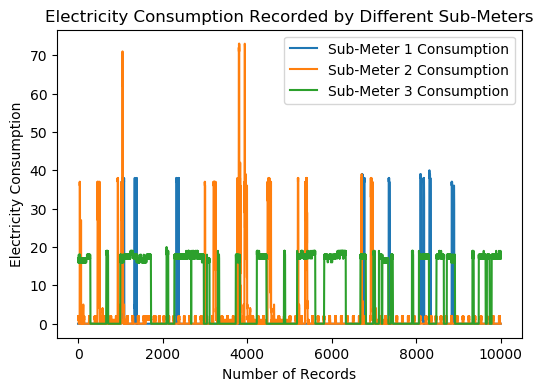

In [6]:
#visualizing graph of electricity consumption of different sub-meters where each sub-meter has consumption for different
#equipments such as water heater, dish washer, washing maching etc
plt.figure(figsize=(6,4))
plt.plot(dataset['Sub_metering_1'], label='Sub-Meter 1 Consumption')
plt.plot(dataset['Sub_metering_2'], label='Sub-Meter 2 Consumption')
plt.plot(dataset['Sub_metering_3'], label='Sub-Meter 3 Consumption')
plt.title("Electricity Consumption Recorded by Different Sub-Meters")
plt.xlabel("Number of Records")
plt.ylabel("Electricity Consumption")
plt.legend()
plt.show()

In [7]:
#applying dataset processing such as converting date and time into numeric values and then summing all 3
#submeters consumption as single target value to forecast future electricity
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['year'] = dataset['Date'].dt.year
dataset['month'] = dataset['Date'].dt.month
dataset['day'] = dataset['Date'].dt.day
dataset['Time'] = pd.to_datetime(dataset['Time'])
dataset['hour'] = dataset['Time'].dt.hour
dataset['minute'] = dataset['Time'].dt.minute
dataset['second'] = dataset['Time'].dt.second
dataset['label'] = dataset['Sub_metering_1'] + dataset['Sub_metering_2'] + dataset['Sub_metering_3']
dataset.drop(['Date', 'Time', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'], axis = 1,inplace=True)
dataset.fillna(0, inplace = True)
dataset

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,year,month,day,hour,minute,second,label
0,4.216,0.418,234.84,18.4,2006,12,16,17,24,0,18.0
1,5.360,0.436,233.63,23.0,2006,12,16,17,25,0,17.0
2,5.374,0.498,233.29,23.0,2006,12,16,17,26,0,19.0
3,5.388,0.502,233.74,23.0,2006,12,16,17,27,0,18.0
4,3.666,0.528,235.68,15.8,2006,12,16,17,28,0,18.0
...,...,...,...,...,...,...,...,...,...,...,...
9995,4.958,0.664,241.34,20.6,2006,12,23,15,59,0,17.0
9996,4.954,0.666,241.50,20.6,2006,12,23,16,0,0,18.0
9997,4.932,0.658,240.80,20.6,2006,12,23,16,1,0,18.0
9998,4.926,0.660,240.77,20.6,2006,12,23,16,2,0,18.0


In [8]:
#applying MIC (Maximal Information Coefficient) algorithm to select least similar or correlated features to avoid 
#poor prediction values
Y = dataset['label'].ravel() #getting target column
dataset.drop(['label'], axis = 1,inplace=True)
columns = dataset.columns
X = dataset.values #get dataset features
print("Total features exists in Dataset before applying MIC features Selection algorithm : "+str(X.shape[1]))
mic_scores = []
mine = MINE()
for i in range(0, len(columns)-1):#loop and compute mic score for each features
    mine.compute_score(X[:,i], Y)
    mic_scores.append((columns[i], mine.mic()))
# Sort features by MIC score
mic_scores.sort(key=lambda x: x[1], reverse=True)
# Select top features
top_features = [feature for feature, _ in mic_scores[:8]]  # Select top 2 features
X = dataset[top_features]
print("Total features exists in Dataset before applying MIC features Selection algorithm : "+str(X.shape[1]))
X = dataset.values

Total features exists in Dataset before applying MIC features Selection algorithm : 10
Total features exists in Dataset before applying MIC features Selection algorithm : 8


In [9]:
#normalizing selected features using MINMAX scaler
Y = Y.reshape(-1, 1)
scaler = MinMaxScaler((0,1))
scaler1 = MinMaxScaler((0,1))
X = dataset.values
X = scaler.fit_transform(X)
Y = scaler1.fit_transform(Y)
print("Normalized Features = "+str(X))

Normalized Features = [[0.53475393 0.57734807 0.94131794 ... 0.73913043 0.40677966 0.        ]
 [0.67985794 0.60220994 0.93646785 ... 0.73913043 0.42372881 0.        ]
 [0.68163369 0.6878453  0.93510502 ... 0.73913043 0.44067797 0.        ]
 ...
 [0.62557078 0.90883978 0.96520763 ... 0.69565217 0.01694915 0.        ]
 [0.62480974 0.91160221 0.96508738 ... 0.69565217 0.03389831 0.        ]
 [0.59081684 0.91160221 0.96524772 ... 0.69565217 0.05084746 0.        ]]


In [10]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Train & Test Dataset Split")
print("80% records used to train algorithms : "+str(X_train.shape[0]))
print("20% records features used to test algorithms : "+str(X_test.shape[0]))

Train & Test Dataset Split
80% records used to train algorithms : 8000
20% records features used to test algorithms : 2000


In [11]:
#defining global variables to save algorithm performnace metrics
rsquare = []
rmse = []
mae = []

In [12]:
#function to calculate MSE, RMSE and R2Square from predicted and true values
def calculateMetrics(algorithm, predict, test_labels):
    mse_error = mean_squared_error(test_labels, predict)
    mae_error = mean_absolute_error(test_labels, predict)
    r2_scores = r2_score(test_labels, predict)
    rmse_error = sqrt(mse_error)
    rsquare.append(r2_scores)
    rmse.append(rmse_error)
    mae.append(mae_error)
    predict = predict.reshape(-1, 1)
    predict = scaler1.inverse_transform(predict)
    test_label = scaler1.inverse_transform(test_labels)
    predict = predict.ravel()
    test_label = test_label.ravel()
    print()
    print(algorithm+" MAE : "+str(mae_error))
    print(algorithm+" RMSE : "+str(rmse_error))
    print(algorithm+" R2 : "+str(r2_scores))
    print()
    for i in range(0, 10):
        print("True Electricity Consumption : "+str(test_label[i])+" Predicted Consumption : "+str(predict[i]))
    plt.figure(figsize=(5,3))
    plt.plot(test_label[0:100], color = 'red', label = 'True Electricity Consumption')
    plt.plot(predict[0:100], color = 'green', label = 'Predicted Electricity Consumption')
    plt.title(algorithm+' Electricity Consumption Forecasting Graph')
    plt.xlabel('Number of Test Samples')
    plt.ylabel('Electricity Consumption Forecasting')
    plt.legend()
    plt.show()   


Existing SVM MAE : 0.05350801799682336
Existing SVM RMSE : 0.06426391935264743
Existing SVM R2 : 0.6588892846301799

True Electricity Consumption : 0.0 Predicted Consumption : 7.846426595704897
True Electricity Consumption : 18.0 Predicted Consumption : 11.283167288450466
True Electricity Consumption : 19.0 Predicted Consumption : 18.830931500585386
True Electricity Consumption : 0.0 Predicted Consumption : 11.167099093437574
True Electricity Consumption : 3.0 Predicted Consumption : 5.506415431207096
True Electricity Consumption : 1.0 Predicted Consumption : 4.449016566013346
True Electricity Consumption : 18.0 Predicted Consumption : 17.234148020093098
True Electricity Consumption : 0.0 Predicted Consumption : 11.850444988468807
True Electricity Consumption : 18.0 Predicted Consumption : 9.999712345308337
True Electricity Consumption : 17.0 Predicted Consumption : 22.808614408963187


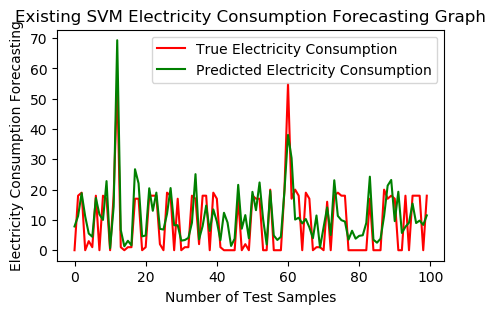

In [13]:
#training existing SVM algorithm on 80% training features and then testing performance on 20% test features
svm_cls = svm.SVR()
#train svm on training data
svm_cls.fit(X_train, y_train.ravel())
#perform prediction on test data
predict = svm_cls.predict(X_test)
#call this function to calculate SVM RMSE and other error values
calculateMetrics("Existing SVM", predict, y_test)


Existing Linear Regression MAE : 0.05315283279699254
Existing Linear Regression RMSE : 0.07884968605904638
Existing Linear Regression R2 : 0.4864758394273242

True Electricity Consumption : 0.0 Predicted Consumption : 19.049124394814818
True Electricity Consumption : 18.0 Predicted Consumption : 8.931087228482113
True Electricity Consumption : 19.0 Predicted Consumption : 18.507702890920697
True Electricity Consumption : 0.0 Predicted Consumption : 12.171639592889031
True Electricity Consumption : 3.0 Predicted Consumption : 1.7815065801477583
True Electricity Consumption : 1.0 Predicted Consumption : 0.8470191457510753
True Electricity Consumption : 18.0 Predicted Consumption : 27.319948902329617
True Electricity Consumption : 0.0 Predicted Consumption : 10.196678664378636
True Electricity Consumption : 18.0 Predicted Consumption : 8.980414651443866
True Electricity Consumption : 17.0 Predicted Consumption : 18.115982304367776


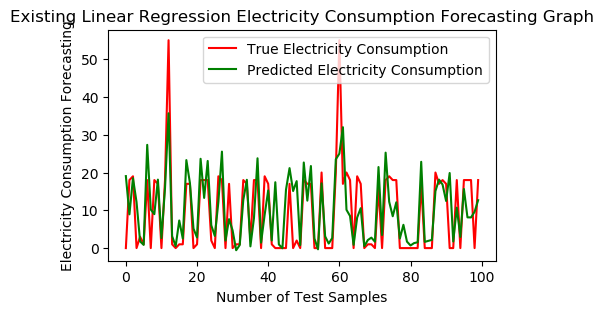

In [14]:
#training existing LinearRegression algorithm on 80% training features and then testing performance on 20% test features
lr_cls = LinearRegression()
#train LinearRegression on training data
lr_cls.fit(X_train, y_train)
#perform prediction on test data
predict = lr_cls.predict(X_test)
#call this function to calculate linear Regression RMSE and other error values
calculateMetrics("Existing Linear Regression", predict, y_test)




Propose CNN-BiLSTM-SA MAE : 0.010692422778159379
Propose CNN-BiLSTM-SA RMSE : 0.02124352700972949
Propose CNN-BiLSTM-SA R2 : 0.9627252970844701

True Electricity Consumption : 0.0 Predicted Consumption : 1.9360781
True Electricity Consumption : 18.0 Predicted Consumption : 18.649492
True Electricity Consumption : 19.0 Predicted Consumption : 19.182194
True Electricity Consumption : 0.0 Predicted Consumption : 2.4405565
True Electricity Consumption : 3.0 Predicted Consumption : 0.83889765
True Electricity Consumption : 1.0 Predicted Consumption : 0.50005084
True Electricity Consumption : 18.0 Predicted Consumption : 17.866287
True Electricity Consumption : 0.0 Predicted Consumption : 2.2825854
True Electricity Consumption : 18.0 Predicted Consumption : 17.726664
True Electricity Consumption : 17.0 Predicted Consumption : 18.171238


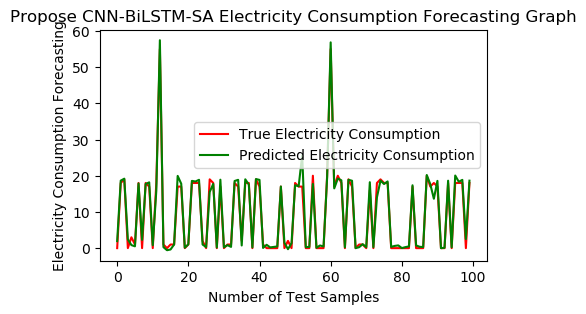

In [15]:
#training propose CNN-BiLSTM-SA algorithm on training features and then evaluate performance on 20% test features
#this algorithm is a combination of CNN, BI-LSTM and SA (self attention)
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1, 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, 1))
propose_model = Sequential()
#adding CNN layer
propose_model.add(Convolution2D(32, (1 , 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
propose_model.add(MaxPooling2D(pool_size = (1, 1)))
propose_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
propose_model.add(MaxPooling2D(pool_size = (1, 1)))
propose_model.add(Flatten())
propose_model.add(RepeatVector(3))
propose_model.add(attention(return_sequences=True,name='attention')) # ========adding Attention layer
#adding bidirectional LSTM as CRNN layer
propose_model.add(Bidirectional(LSTM(64, activation = 'relu')))#==================adding BILSTM
propose_model.add(RepeatVector(3))
propose_model.add(Bidirectional(LSTM(64, activation = 'relu')))#==================adding BILSTM
#defining output classification layer with 256 neurons 
propose_model.add(Dense(units = 256, activation = 'relu'))
propose_model.add(Dropout(0.3))
propose_model.add(Dense(units = 1))
propose_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
if os.path.exists("model/propose_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/propose_weights.hdf5', verbose = 1, save_best_only = True)
    hist = propose_model.fit(X_train1, y_train, batch_size = 16, epochs = 50, validation_data=(X_test1, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/propose_hist.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    propose_model.load_weights("model/propose_weights.hdf5")
#perform prediction on test data
predict = propose_model.predict(X_test1)
#call this function to calculate propose RMSE and other error values
calculateMetrics("Propose CNN-BiLSTM-SA", predict, y_test)


Extension CNN-BiGRU-SA MAE : 0.009547446492493152
Extension CNN-BiGRU-SA RMSE : 0.0187536353580782
Extension CNN-BiGRU-SA R2 : 0.9709509536754457

True Electricity Consumption : 0.0 Predicted Consumption : 2.3063114
True Electricity Consumption : 18.0 Predicted Consumption : 18.166582
True Electricity Consumption : 19.0 Predicted Consumption : 19.519403
True Electricity Consumption : 0.0 Predicted Consumption : 1.4809538
True Electricity Consumption : 3.0 Predicted Consumption : 1.434742
True Electricity Consumption : 1.0 Predicted Consumption : 1.019931
True Electricity Consumption : 18.0 Predicted Consumption : 17.609228
True Electricity Consumption : 0.0 Predicted Consumption : 0.05214801
True Electricity Consumption : 18.0 Predicted Consumption : 18.21033
True Electricity Consumption : 17.0 Predicted Consumption : 16.809198


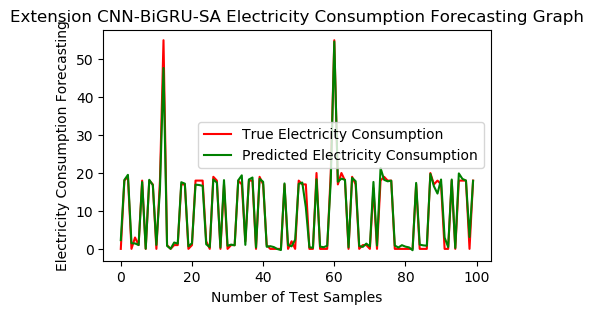

In [16]:
#training extension CNN-BiGRU-SA algorithm on training features and then evaluate performance on 20% test features
#this algorithm is a combination of CNN, BI-GRU and SA (self attention)
#as extension we have modified LSTM with GRU and after using GRU wwe found better R2score as GRU is better in prediction 
#rate compare to LSTM and this better prediction will reduce RMSE error further
extension_model = Sequential()
extension_model.add(Convolution2D(32, (1 , 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
extension_model.add(MaxPooling2D(pool_size = (1, 1)))
extension_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
extension_model.add(MaxPooling2D(pool_size = (1, 1)))
extension_model.add(Flatten())
extension_model.add(RepeatVector(3))
extension_model.add(attention(return_sequences=True,name='attention')) # ========define Attention layer
#adding bidirectional LSTM as CRNN layer
extension_model.add(Bidirectional(GRU(64, activation = 'relu')))#==================adding BIGRU
extension_model.add(RepeatVector(3))
extension_model.add(Bidirectional(GRU(64, activation = 'relu')))#==================adding BIGRU
#defining output classification layer with 256 neurons 
extension_model.add(Dense(units = 256, activation = 'relu'))
extension_model.add(Dropout(0.3))
extension_model.add(Dense(units = 1))
extension_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
if os.path.exists("model/extension_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/extension_weights.hdf5', verbose = 1, save_best_only = True)
    hist = extension_model.fit(X_train1, y_train, batch_size = 16, epochs = 50, validation_data=(X_test1, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/extension_hist.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    extension_model.load_weights("model/extension_weights.hdf5")
#perform prediction on test data
predict = extension_model.predict(X_test1)
#call this function to calculate extension RMSE and other error values
calculateMetrics("Extension CNN-BiGRU-SA", predict, y_test)

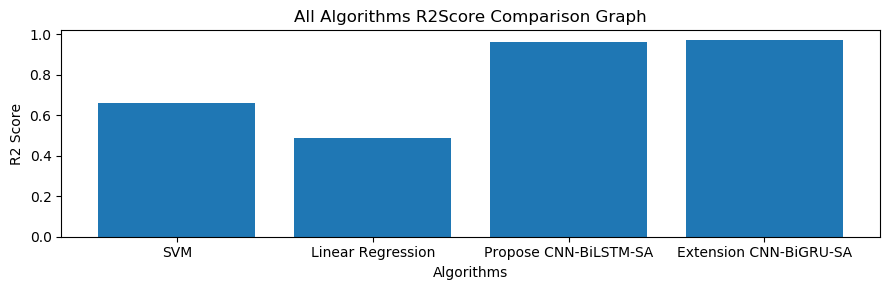

In [17]:
#visualizing RMSE performance of all algorithms
height = rsquare
bars = ['SVM', 'Linear Regression', 'Propose CNN-BiLSTM-SA', 'Extension CNN-BiGRU-SA']
y_pos = np.arange(len(bars))
plt.figure(figsize = (9, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Algorithms")
plt.ylabel("R2 Score")
plt.title("All Algorithms R2Score Comparison Graph")
plt.tight_layout()
plt.show()

In [18]:
#display all algorithm performnace
algorithms = ['Existing SVM', 'Existing Linear Regression', 'Propose CNN-BiLSTM-SA', 'Extension CNN-BiGRU-SA']
data = []
for i in range(len(rmse)):
    data.append([algorithms[i], rsquare[i], rmse[i], mae[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'R2Score', 'RMSE', 'MAE'])
data  

,Algorithm Name,R2Score,RMSE,MAE
0,Existing SVM,0.658889,0.064264,0.053508
1,Existing Linear Regression,0.486476,0.078850,0.053153
2,Propose CNN-BiLSTM-SA,0.962725,0.021244,0.010692
3,Extension CNN-BiGRU-SA,0.970951,0.018754,0.009547


In [19]:
#reading test data and then predicting dosage
testData = pd.read_csv("Dataset/testData.csv", sep=";")#read test data
data = testData.values
#handling and removing missing values        
testData.fillna(0, inplace = True)
testData['Date'] = pd.to_datetime(testData['Date'])#convert date and time to year, month, day, hour, second and minutes
testData['year'] = testData['Date'].dt.year
testData['month'] = testData['Date'].dt.month
testData['day'] = testData['Date'].dt.day
testData['Time'] = pd.to_datetime(testData['Time'])
testData['hour'] = testData['Time'].dt.hour
testData['minute'] = testData['Time'].dt.minute
testData['second'] = testData['Time'].dt.second
testData.drop(['Date', 'Time'], axis = 1,inplace=True)
testData.fillna(0, inplace = True)
X = testData[top_features]#select MIC top features
testData = testData.values
testData = scaler.transform(testData)#normalize dataset values
testData = np.reshape(testData, (testData.shape[0], testData.shape[1], 1, 1))
predict = extension_model.predict(testData)#predict electricity consumption using extension model
predict = predict.reshape(-1, 1)
predict = scaler1.inverse_transform(predict)#reverse normalize predicted SOC to normal integer value
for i in range(len(predict)):
    print("Test Data = "+str(data[i])+" Predicted Electricity Consumption ===> "+str(abs(predict[i,0])))
    print()

Test Data = ['16/12/2006' '17:59:00' 2.472 0.058 236.94 10.4] Predicted Electricity Consumption ===> 18.45964

Test Data = ['16/12/2006' '18:00:00' 2.79 0.18 237.52 11.8] Predicted Electricity Consumption ===> 17.8724

Test Data = ['16/12/2006' '19:21:00' 3.332 0.0 234.02 14.2] Predicted Electricity Consumption ===> 17.465376

Test Data = ['18/12/2006' '23:51:00' 0.442 0.266 245.21 2.0] Predicted Electricity Consumption ===> 1.9466225

Test Data = ['18/12/2006' '23:52:00' 0.442 0.266 244.93 2.0] Predicted Electricity Consumption ===> 1.9013784

Test Data = ['18/12/2006' '23:53:00' 0.448 0.262 244.19 2.2] Predicted Electricity Consumption ===> 1.8946817

Test Data = ['18/12/2006' '23:40:00' 1.296 0.0 244.2 6.0] Predicted Electricity Consumption ===> 13.635263

Test Data = ['18/12/2006' '23:41:00' 2.006 0.0 243.5 8.6] Predicted Electricity Consumption ===> 31.714886

Test Data = ['18/12/2006' '23:42:00' 0.558 0.054 245.09 3.0] Predicted Electricity Consumption ===> 3.3292425



In [20]:
#=================flask code starts here
from flask import Flask, render_template, request, redirect, url_for, session,send_from_directory

In [21]:
app = Flask(__name__)
app.secret_key = 'welcome'

In [22]:
@app.route('/Predict', methods=['GET', 'POST'])
def predictView():
    return render_template('Predict.html', msg='')

@app.route('/', methods=['GET', 'POST'])
def index():
    return render_template('index.html', msg='')

@app.route('/index', methods=['GET', 'POST'])
def index1():
    return render_template('index.html', msg='')


def getModel():
    extension_model = Sequential()
    extension_model.add(Convolution2D(32, (1 , 1), input_shape = (10, 1, 1), activation = 'relu'))
    extension_model.add(MaxPooling2D(pool_size = (1, 1)))
    extension_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
    extension_model.add(MaxPooling2D(pool_size = (1, 1)))
    extension_model.add(Flatten())
    extension_model.add(RepeatVector(3))
    extension_model.add(attention(return_sequences=True,name='attention')) # ========define Attention layer
    #adding bidirectional LSTM as CRNN layer
    extension_model.add(Bidirectional(GRU(64, activation = 'relu')))#==================adding BIGRU
    extension_model.add(RepeatVector(3))
    extension_model.add(Bidirectional(GRU(64, activation = 'relu')))#==================adding BIGRU
    #defining output classification layer with 256 neurons 
    extension_model.add(Dense(units = 256, activation = 'relu'))
    extension_model.add(Dropout(0.3))
    extension_model.add(Dense(units = 1))
    extension_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    extension_model.load_weights("model/extension_weights.hdf5")
    return extension_model

@app.route('/AdminLogin', methods=['GET', 'POST'])
def AdminLogin():
    return render_template('AdminLogin.html', msg='')

@app.route('/AdminLoginAction', methods=['GET', 'POST'])
def AdminLoginAction():
    if request.method == 'POST' and 't1' in request.form and 't2' in request.form:
        user = request.form['t1']
        password = request.form['t2']
        if user == "admin" and password == "admin":
            return render_template('AdminScreen.html', msg="Welcome "+user)
        else:
            return render_template('AdminLogin.html', msg="Invalid login details")

@app.route('/Logout')
def Logout():
    return render_template('index.html', msg='')

@app.route('/PredictAction', methods=['GET', 'POST'])
def PredictAction():
    if request.method == 'POST':
        extension_model = getModel()
        #reading test data and then predicting dosage
        testData = pd.read_csv("Dataset/testData.csv", sep=";")#read test data
        data = testData.values
        #handling and removing missing values        
        testData.fillna(0, inplace = True)
        testData['Date'] = pd.to_datetime(testData['Date'])#convert date and time to year, month, day, hour, second and minutes
        testData['year'] = testData['Date'].dt.year
        testData['month'] = testData['Date'].dt.month
        testData['day'] = testData['Date'].dt.day
        testData['Time'] = pd.to_datetime(testData['Time'])
        testData['hour'] = testData['Time'].dt.hour
        testData['minute'] = testData['Time'].dt.minute
        testData['second'] = testData['Time'].dt.second
        testData.drop(['Date', 'Time'], axis = 1,inplace=True)
        testData.fillna(0, inplace = True)
        X = testData[top_features]#select MIC top features
        testData = testData.values
        testData = scaler.transform(testData)#normalize dataset values
        testData = np.reshape(testData, (testData.shape[0], testData.shape[1], 1, 1))
        predict = extension_model.predict(testData)#predict electricity consumption using extension model
        predict = predict.reshape(-1, 1)
        predict = scaler1.inverse_transform(predict)#reverse normalize predicted SOC to normal integer value
        output = ""
        for i in range(len(predict)):
            output += "Test Data = "+str(data[i])+" Predicted Electricity Consumption ===> "+str(predict[i,0])+"<br/><br/>"
        return render_template('Predict.html', msg=output)

In [ ]:
if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
